In [1]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12})
plt.rc('axes', xmargin=0, ymargin=0)
import matplotlib.ticker as ticker
import array_to_latex as a2l
from pandas_datareader.famafrench import FamaFrenchReader

"""
Own packages
"""

from codelib.population_parameters import calculate_mean, calculate_cov_mat, cov_to_corr_matrix, cov_to_corr_and_vols, calculate_exponential_decay_probabilities
from codelib.portfolio_measures import calculate_risk_contributions_std
from codelib.portfolio_performance_measures import drawdown, maxdrawdown, calculate_cc_ratio
from codelib.portfolio_optimizers import calculate_max_sharpe_portfolio, calculate_min_var_portfolio, calculate_most_diversified_portfolio, nrp_portfolio, calculate_rp_portfolio

# Load datasets

In [2]:
# get daily fama-french factors
ff_factors_daily_dict = FamaFrenchReader("F-F_Research_Data_Factors_Daily", start='1970-01-01', end='2023-01-01').read()
ff_factors_daily_dict['DESCR']

'F-F Research Data Factors Daily\n-------------------------------\n\nThis file was created by CMPT_ME_BEME_RETS_DAILY using the 202303 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2023 Kenneth R. French\n\n  0 : (13369 rows x 4 cols)'

In [3]:
# get daily risk-free rate (US one month T-Bill return)
us_t_bill_daily = pd.DataFrame(ff_factors_daily_dict[0]['RF']) / 100
#us_t_bill_daily.to_csv(r'C:\code\masters_thesis\data\us_one_month_t_bill_daily_returns.csv')

In [4]:
# get daily returns
ff10_daily_dict = FamaFrenchReader('10_Industry_Portfolios_Daily', start='1970-01-01', end='2023-01-01').read()
ff10_daily_dict['DESCR']

'10 Industry Portfolios Daily\n----------------------------\n\nThis file was created by CMPT_IND_RETS_DAILY using the 202303 CRSP database. It contains value- and equal-weighted returns for 10 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Daily (13369 rows x 10 cols)\n  1 : Average Equal Weighted Returns -- Daily (13369 rows x 10 cols)'

In [5]:
# calculate cummulative return index
ff10_daily_ret = ff10_daily_dict[0] / 100
ff10_daily_ret.to_csv(r'C:\code\masters_thesis\data\ff_10_daily_returns.csv')
ff10_cum_ret_ind = (1 + ff10_daily_ret).cumprod()

# calculate weekly returns
ff10_weekly_cum_ret = ff10_cum_ret_ind.resample('W-WED').last()
ff10_weekly_cum_ret.drop(ff10_weekly_cum_ret.tail(1).index,inplace=True)
ff10_weekly_ret = ff10_weekly_cum_ret / ff10_weekly_cum_ret.shift(1) - 1
ff10_weekly_ret.drop(ff10_weekly_ret.head(1).index, inplace=True)
ff10_weekly_ret.columns = [_.strip() for _ in ff10_weekly_ret.columns]

In [6]:
# calculate cummulative excess-return index
ff10_daily_ret = ff10_daily_dict[0] / 100
ff10_daily_excess_ret = ff10_daily_ret.sub(us_t_bill_daily['RF'], axis=0)
ff10_cum_excess_ret_ind = (1 + ff10_daily_excess_ret).cumprod()

# calculate weekly returns
ff10_weekly_cum_excess_ret = ff10_cum_excess_ret_ind.resample('W-WED').last()
ff10_weekly_cum_excess_ret.drop(ff10_weekly_cum_excess_ret.tail(1).index,inplace=True)
ff10_weekly_excess_ret = ff10_weekly_cum_excess_ret / ff10_weekly_cum_excess_ret.shift(1) - 1
ff10_weekly_excess_ret.drop(ff10_weekly_excess_ret.head(1).index, inplace=True)
ff10_weekly_excess_ret.columns = [_.strip() for _ in ff10_weekly_excess_ret.columns]
assets = np.array(ff10_weekly_excess_ret.columns)

# Calculate historical av. excess return (ann.), volatilities (ann.) and correlations over sample period

In [7]:
real_cov = np.cov(ff10_weekly_ret.T, bias=True)
real_corr, real_vols = cov_to_corr_and_vols(real_cov)
a2l.to_ltx(np.triu(real_corr),frmt='{:6.2f}', arraytype='bmatrix', print_out=True)

\begin{bmatrix}
    1.00 &    0.64 &    0.82 &    0.53 &    0.63 &    0.64 &    0.80 &    0.76 &    0.64 &    0.78\\
    0.00 &    1.00 &    0.80 &    0.53 &    0.69 &    0.61 &    0.75 &    0.57 &    0.48 &    0.78\\
    0.00 &    0.00 &    1.00 &    0.67 &    0.78 &    0.70 &    0.84 &    0.73 &    0.60 &    0.89\\
    0.00 &    0.00 &    0.00 &    1.00 &    0.48 &    0.49 &    0.50 &    0.45 &    0.55 &    0.61\\
    0.00 &    0.00 &    0.00 &    0.00 &    1.00 &    0.65 &    0.74 &    0.65 &    0.43 &    0.75\\
    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    1.00 &    0.66 &    0.58 &    0.58 &    0.73\\
    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    1.00 &    0.73 &    0.54 &    0.83\\
    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    1.00 &    0.51 &    0.71\\
    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    1.00 &    0.60\\
    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0

In [8]:
ff10_weekly_excess_ret.mean(axis=0) * 52

NoDur    0.082672
Durbl    0.071550
Manuf    0.073541
Enrgy    0.089477
HiTec    0.073703
Telcm    0.062319
Shops    0.080420
Hlth     0.080031
Utils    0.065635
Other    0.068359
dtype: float64

In [9]:
ff10_weekly_ret.std(ddof = 0, axis=0) * np.sqrt(52)

NoDur    0.146166
Durbl    0.245885
Manuf    0.175907
Enrgy    0.225234
HiTec    0.228711
Telcm    0.172531
Shops    0.183428
Hlth     0.177449
Utils    0.146187
Other    0.194598
dtype: float64

In [10]:
ff10_weekly_excess_ret.mean(axis=0) / ff10_weekly_ret.std(ddof=0, axis=0) * np.sqrt(52)

NoDur    0.565606
Durbl    0.290990
Manuf    0.418066
Enrgy    0.397262
HiTec    0.322253
Telcm    0.361203
Shops    0.438430
Hlth     0.451008
Utils    0.448981
Other    0.351280
dtype: float64

# Back-test with weekly rebalancing

In [11]:
"""
Initialize values
"""

num_periods = len(ff10_weekly_excess_ret)
num_assets = ff10_weekly_excess_ret.shape[1]
estimation_window =  52 * 5 # 5 years of weekly observations
eff_num_periods = num_periods - estimation_window
half_life = 52 * 2 # two years with weekly observations
time_points = np.arange(1, estimation_window + 1)
exp_probs = calculate_exponential_decay_probabilities(estimation_window, time_points, half_life)

In [38]:
"""
Calculate optimal weights
"""
max_sr_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_weights = np.zeros((eff_num_periods, num_assets))
most_div_port_weights = np.zeros((eff_num_periods, num_assets))
rp_port_weights = np.zeros((eff_num_periods, num_assets))
nrp_port_weights = np.zeros((eff_num_periods, num_assets))

max_sr_port_cc = np.zeros(eff_num_periods)
min_var_port_cc = np.zeros(eff_num_periods)
most_div_port_cc = np.zeros(eff_num_periods)
rp_port_cc = np.zeros(eff_num_periods)
nrp_port_cc = np.zeros(eff_num_periods)

"""
Perform calculations for portfolio weights and diversification ratio
"""

for t in range(eff_num_periods):

    # covariance matrix and mu
    cov_mat = calculate_cov_mat(ff10_weekly_excess_ret.iloc[t: estimation_window + t, :].values, probs=exp_probs)
    mu = calculate_mean(ff10_weekly_excess_ret.iloc[t: estimation_window + t, :].values, probs=exp_probs)

    # maximum sharpe
    max_sr_port_weights[t, :] = calculate_max_sharpe_portfolio(mu, cov_mat, rf=0)
    max_sr_port_cc[t] = calculate_cc_ratio(max_sr_port_weights[t, :], cov_mat)

    # minimum variance
    min_var_port_weights[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc[t] = calculate_cc_ratio(min_var_port_weights[t, :], cov_mat)

    # most diversified
    most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights[t, :], cov_mat)

    # risk parity
    rp_port_weights[t, :] = calculate_rp_portfolio(cov_mat)
    rp_port_cc[t] = calculate_cc_ratio(rp_port_weights[t, :], cov_mat)

    # naive risk parity
    nrp_port_weights[t, :] = nrp_portfolio(cov_mat)
    nrp_port_cc[t] = calculate_cc_ratio(nrp_port_weights[t, :], cov_mat)

In [13]:
"""
store optimal weights in dataframes
"""
df_max_sr_port_weights = pd.DataFrame(data=max_sr_port_weights,
                                        index=ff10_weekly_excess_ret[estimation_window:].index,
                                        columns=ff10_weekly_excess_ret.columns)

df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                        index=ff10_weekly_excess_ret[estimation_window:].index,
                                        columns=ff10_weekly_excess_ret.columns)

df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=ff10_weekly_excess_ret[estimation_window:].index,
                                        columns=ff10_weekly_excess_ret.columns)

df_rp_port_weights = pd.DataFrame(data=rp_port_weights,
                                        index=ff10_weekly_excess_ret[estimation_window:].index,
                                        columns=ff10_weekly_excess_ret.columns)

df_nrp_port_weights = pd.DataFrame(data=nrp_port_weights,
                                        index=ff10_weekly_excess_ret[estimation_window:].index,
                                        columns=ff10_weekly_excess_ret.columns)

In [14]:
"""
calculate av. estimated correlations
"""

avg_corr = np.zeros(eff_num_periods)
upper_tri_idx = np.triu_indices(num_assets)

for t in range(eff_num_periods):

    cov_mat = calculate_cov_mat(ff10_weekly_excess_ret.iloc[t: estimation_window + t, :].values, probs=exp_probs)
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()

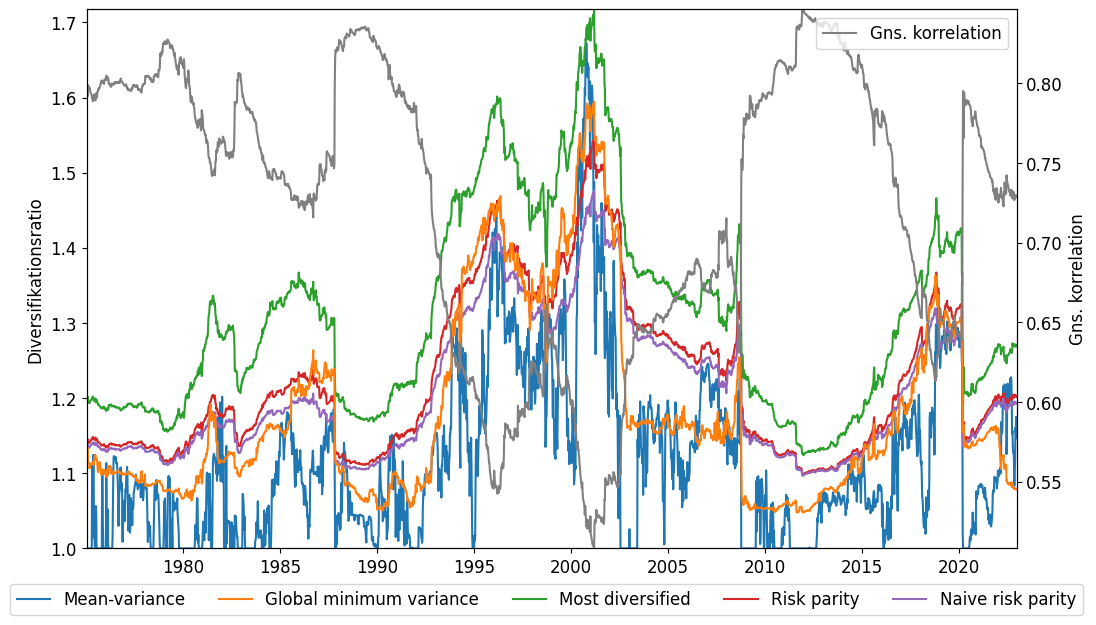

In [15]:
# plot ev. estimated correlations and diversification ratios
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ff10_weekly_excess_ret.index[estimation_window:], max_sr_port_cc, label="Mean-variance")
ax.plot(ff10_weekly_excess_ret.index[estimation_window:], min_var_port_cc, label="Global minimum variance", zorder=10)
ax.plot(ff10_weekly_excess_ret.index[estimation_window:], most_div_port_cc, label="Most diversified")
ax.plot(ff10_weekly_excess_ret.index[estimation_window:], rp_port_cc, label="Risk parity")
ax.plot(ff10_weekly_excess_ret.index[estimation_window:], nrp_port_cc, label="Naive risk parity")
ax.set_ylabel("Diversifikationsratio")

ax_new = ax.twinx()
ax_new.set_ylabel("Gns. korrelation")

ax_new.plot(ff10_weekly_excess_ret.index[estimation_window:], avg_corr, label="Gns. korrelation", color="gray")
ax_new.legend(loc='upper right')
ax.legend(ncol=5, bbox_to_anchor=(1.08, -0.05))
#plt.savefig("avv_cor_and_cc_ratios.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [16]:
# calculate relative risk-contributions
max_sr_rel_risk_contribs = np.zeros((eff_num_periods, num_assets))
min_var_rel_risk_contribs = np.zeros((eff_num_periods, num_assets))
most_div_rel_risk_contribs = np.zeros((eff_num_periods, num_assets))
rp_rel_risk_contribs = np.zeros((eff_num_periods, num_assets))
nrp_rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):

    # covariance matrix
    cov_mat = calculate_cov_mat(ff10_weekly_excess_ret.iloc[t: estimation_window + t, :].values, probs=exp_probs)
    max_sr_rel_risk_contribs[t, :] = calculate_risk_contributions_std(max_sr_port_weights[t,:], cov_mat, scale=True)
    min_var_rel_risk_contribs[t, :] = calculate_risk_contributions_std(min_var_port_weights[t,:], cov_mat, scale=True)
    most_div_rel_risk_contribs[t, :] = calculate_risk_contributions_std(most_div_port_weights[t,:], cov_mat, scale=True)
    rp_rel_risk_contribs[t, :] = calculate_risk_contributions_std(rp_port_weights[t,:], cov_mat, scale=True)
    nrp_rel_risk_contribs[t, :] = calculate_risk_contributions_std(nrp_port_weights[t,:], cov_mat, scale=True)

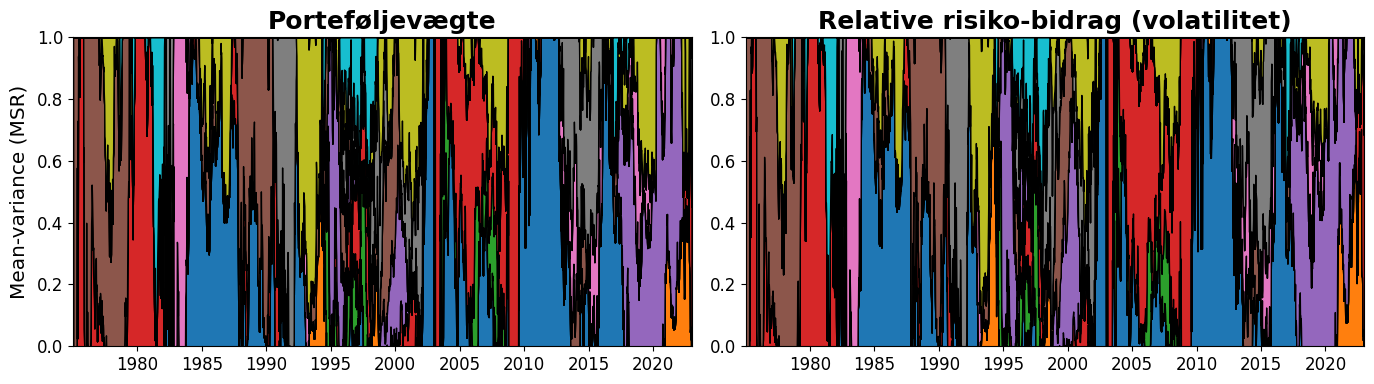

In [17]:
# plot portfolioweights and relative risk-contributions
fig, ax = plt.subplots(1,2, figsize=(14, 4))

ax[0].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              max_sr_port_weights.T,
              edgecolor="black")
ax[0].set_title('Porteføljevægte', fontweight="bold", fontsize = 18)

ax[1].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              max_sr_rel_risk_contribs.T,
              edgecolor="black")
ax[1].set_title('Relative risiko-bidrag (volatilitet)', fontweight="bold", fontsize = 18)

fig.supylabel('Mean-variance (MSR)')
plt.tight_layout()
#plt.savefig("max_sr_weights_and_RRC.jpg",bbox_inches="tight",dpi=300)
plt.show()

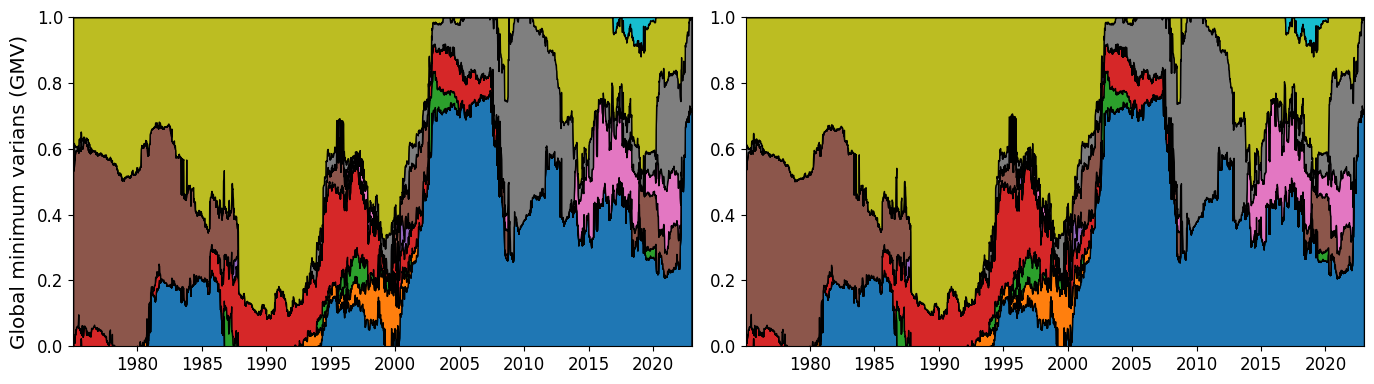

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

ax[0].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              min_var_port_weights.T,
              edgecolor="black")

ax[1].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              min_var_rel_risk_contribs.T,
              edgecolor="black")

fig.supylabel('Global minimum varians (GMV)')
plt.tight_layout()
#plt.savefig("min_var_weights_and_RRC.jpg",bbox_inches="tight",dpi=300)
plt.show()

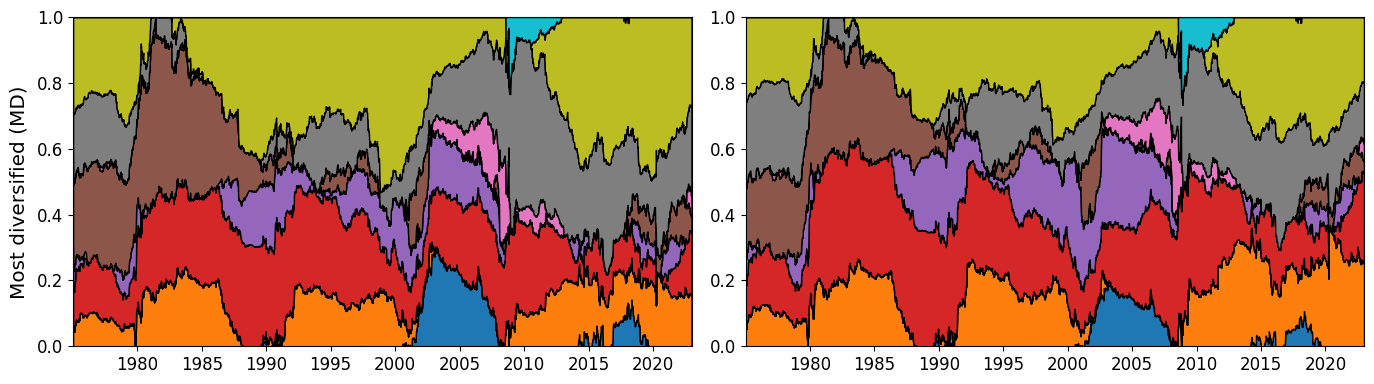

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

ax[0].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              most_div_port_weights.T,
              edgecolor="black")

ax[1].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              most_div_rel_risk_contribs.T,
              edgecolor="black")

fig.supylabel('Most diversified (MD)')
plt.tight_layout()
#plt.savefig("most_div_weights_and_RRC.jpg",bbox_inches="tight",dpi=300)
plt.show()

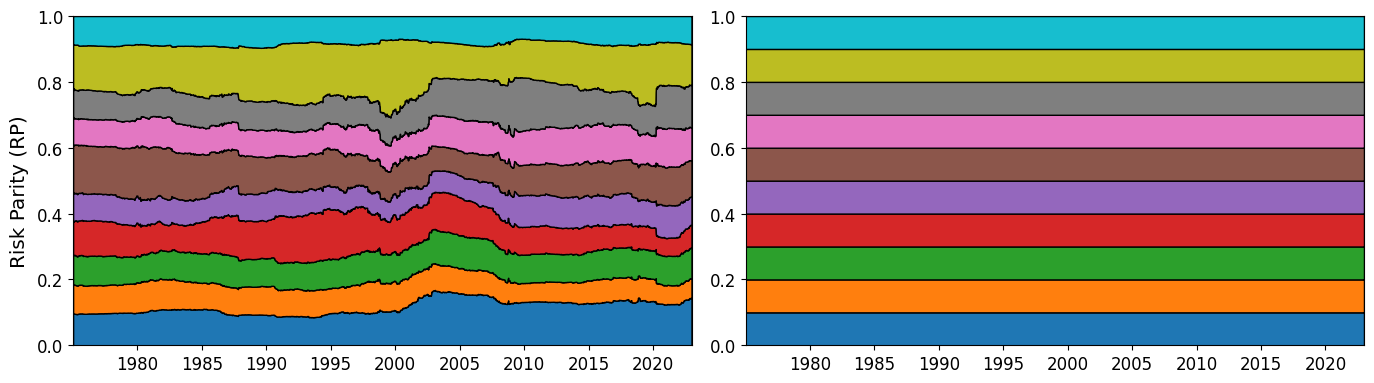

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

ax[0].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              rp_port_weights.T,
              edgecolor="black")

ax[1].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              rp_rel_risk_contribs.T,
              edgecolor="black")

fig.supylabel('Risk Parity (RP)')
plt.tight_layout()
#plt.savefig("rp_weights_and_RRC.jpg",bbox_inches="tight",dpi=300)
plt.show()

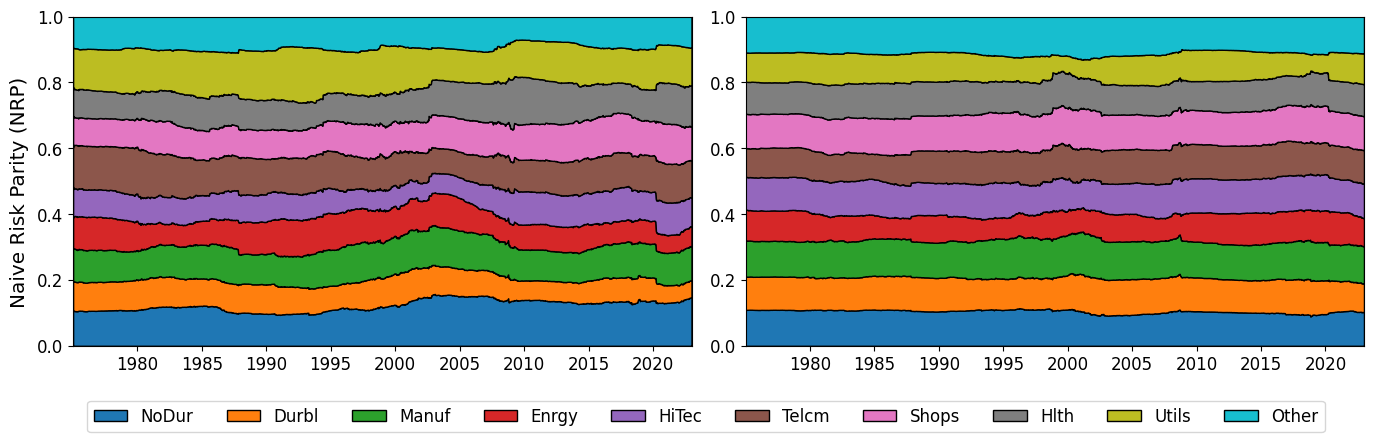

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

ax[0].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              nrp_port_weights.T,
              edgecolor="black")

ax[1].stackplot(ff10_weekly_excess_ret.index[estimation_window:],
              nrp_rel_risk_contribs.T,
              edgecolor="black")

fig.supylabel('Naive Risk Parity (NRP)')
fig.legend(df_max_sr_port_weights.columns, ncol=10, bbox_to_anchor=(0.965, -0.002))
plt.tight_layout()
#plt.savefig("nrp_weights_and_RRC.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Calculate weekly portfolio returns and excess returns

In [22]:
# calculate total return-indices
df_port_ret = pd.DataFrame(index=ff10_weekly_excess_ret.index[estimation_window:])

# weekly return
df_port_ret['max_sr'] = (ff10_weekly_ret[estimation_window:] * df_max_sr_port_weights).sum(axis=1)
df_port_ret['min-var'] = (ff10_weekly_ret[estimation_window:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (ff10_weekly_ret[estimation_window:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['risk-par'] = (ff10_weekly_ret[estimation_window:] * df_rp_port_weights).sum(axis=1)
df_port_ret['n-risk-par'] = (ff10_weekly_ret[estimation_window:] * df_nrp_port_weights).sum(axis=1)


# total excess-return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)

In [23]:
# calculate total excess-return indices
df_port_excess_ret = pd.DataFrame(index=ff10_weekly_excess_ret.index[estimation_window:])

# weekly return
df_port_excess_ret['max_sr'] = (ff10_weekly_excess_ret[estimation_window:] * df_max_sr_port_weights).sum(axis=1)
df_port_excess_ret['min-var'] = (ff10_weekly_excess_ret[estimation_window:] * df_min_var_port_weights).sum(axis=1)
df_port_excess_ret['most-div'] = (ff10_weekly_excess_ret[estimation_window:] * df_most_div_port_weights).sum(axis=1)
df_port_excess_ret['risk-par'] = (ff10_weekly_excess_ret[estimation_window:] * df_rp_port_weights).sum(axis=1)
df_port_excess_ret['n-risk-par'] = (ff10_weekly_excess_ret[estimation_window:] * df_nrp_port_weights).sum(axis=1)


# total excess-return index
df_port_teri = (1 + df_port_excess_ret).cumprod(axis=0)

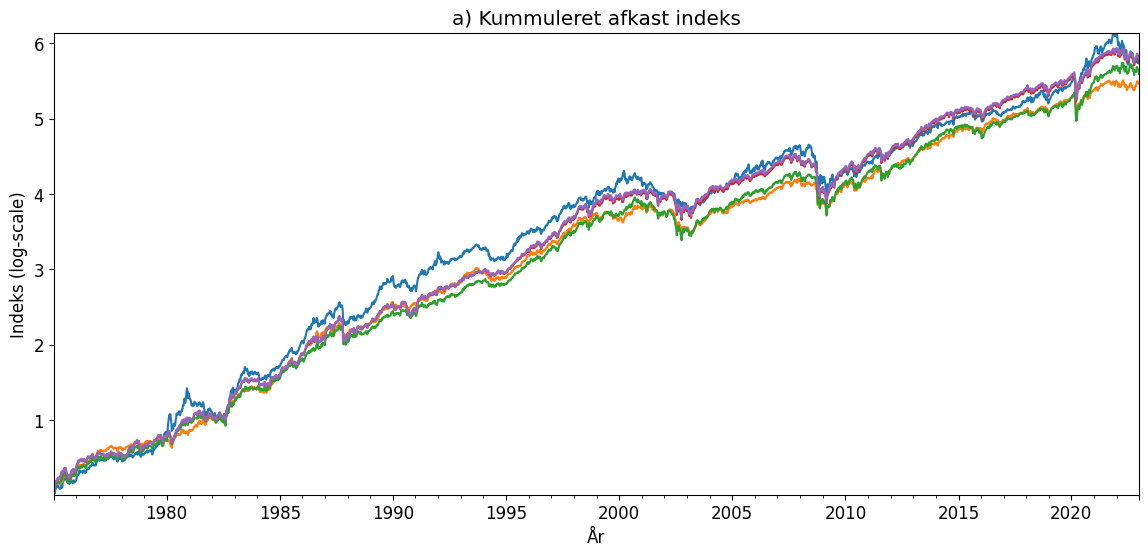

In [24]:
# plot cummulative return index (on log-scale)

fig, ax = plt.subplots(figsize=(14, 6))

legends = ['Mean-variance','Global minimum varians','Most diversified','Risk Parity','Naive Risk Parity']
np.log(df_port_tri).plot(ax=ax, legend=False)

ax.set_ylabel("Indeks (log-scale)")
ax.set_xlabel("År")

ax.set_title("a) Kummuleret afkast indeks")
#plt.savefig("kummuleret_afkast_index.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Drawdowns

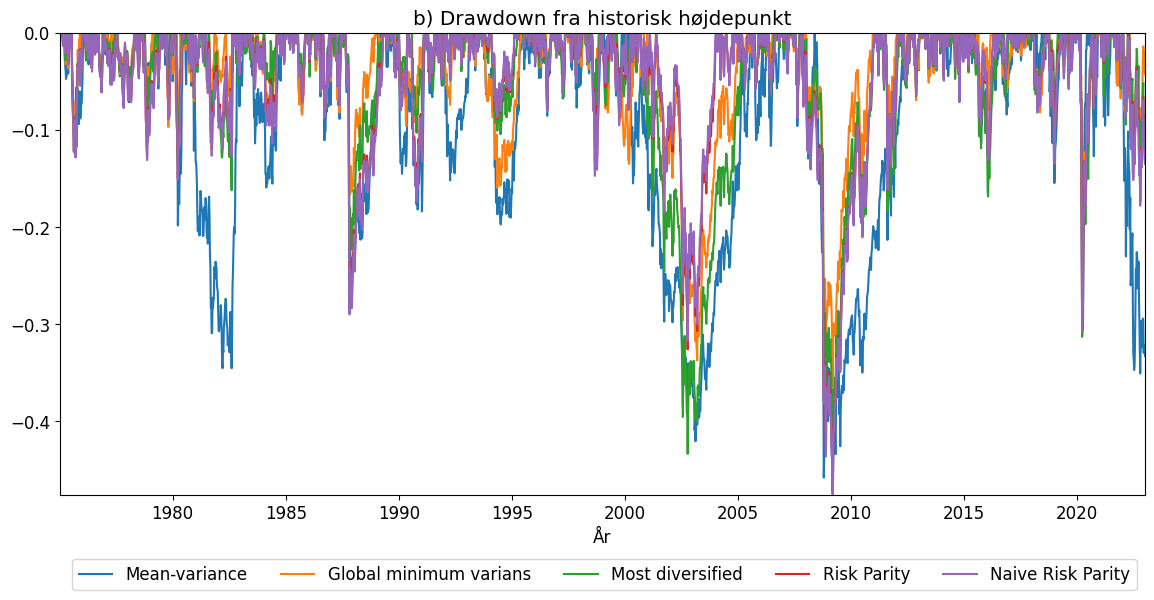

In [25]:
dd_max_sr = drawdown(df_port_tri['max_sr'])[0]
dd_min_var = drawdown(df_port_tri['min-var'])[0]
dd_most_div = drawdown(df_port_tri['most-div'])[0]
dd_rp = drawdown(df_port_tri['risk-par'])[0]
dd_nrp = drawdown(df_port_tri['n-risk-par'])[0]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(dd_max_sr)
ax.plot(dd_min_var)
ax.plot(dd_most_div)
ax.plot(dd_rp)
ax.plot(dd_nrp)

ax.set_title("b) Drawdown fra historisk højdepunkt")
ax.set_xlabel("År")
ax.legend(legends, ncol=5, bbox_to_anchor=(1.0, -0.12))
#plt.savefig("ff10_drawdowns.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Average Out-of-sample performance measures

In [26]:
# average return (arithmetic) annualized
mean_excess_return_arit_ann = df_port_excess_ret.mean(axis=0) * 52
print(mean_excess_return_arit_ann)

max_sr        0.092144
min-var       0.079555
most-div      0.085226
risk-par      0.089244
n-risk-par    0.090024
dtype: float64


In [27]:
# average return (geometric) annualized
mean_excess_return_geom_ann = df_port_teri.values[-1]**(52 / len(df_port_teri)) - 1
print(mean_excess_return_geom_ann*100)

[8.07544142 7.47318406 7.75966101 8.14716302 8.20107408]


In [28]:
# average std. annualized
std_return = df_port_ret.std(axis=0) * np.sqrt(52)
print(std_return*100)

max_sr        16.908370
min-var       12.169263
most-div      14.386585
risk-par      14.672325
n-risk-par    14.860260
dtype: float64


In [29]:
# skewness and kurtosis std. annualized
skew_return = df_port_ret.skew(axis=0)
print(skew_return)
kurt_return = df_port_ret.kurt(axis=0)
print(kurt_return)

max_sr       -0.688103
min-var      -0.600964
most-div     -0.741087
risk-par     -0.751881
n-risk-par   -0.748236
dtype: float64
max_sr        4.618389
min-var       5.438120
most-div      6.085135
risk-par      5.832562
n-risk-par    5.709948
dtype: float64


In [30]:
# Sharpe ratio
sr = mean_excess_return_arit_ann / std_return
print(sr)

max_sr        0.544960
min-var       0.653739
most-div      0.592399
risk-par      0.608245
n-risk-par    0.605805
dtype: float64


In [31]:
# Maximum drawdown
print(maxdrawdown(df_port_tri['max_sr']))
print(maxdrawdown(df_port_tri['min-var']))
print(maxdrawdown(df_port_tri['most-div']))
print(maxdrawdown(df_port_tri['risk-par']))
print(maxdrawdown(df_port_tri['n-risk-par']))

-0.4723239574207529
-0.3643740405453222
-0.43955369527116916
-0.4720188598821955
-0.47583593377666816


In [32]:
# Turnover

df_adj_max_sr_port_weights = (1 + ff10_weekly_ret[estimation_window:]) * df_max_sr_port_weights
df_adj_max_sr_port_weights = df_adj_max_sr_port_weights.divide(1+df_port_ret['max_sr'].values, axis=0)
df_w_diff_max_sr = (df_adj_max_sr_port_weights.shift(1) - df_max_sr_port_weights).dropna()
weekly_turnover_max_sr = np.linalg.norm(df_w_diff_max_sr, axis=1, ord=1) * 100
turn_over_max_sr = np.mean(weekly_turnover_max_sr)

df_adj_min_var_port_weights = (1 + ff10_weekly_ret[estimation_window:]) * df_min_var_port_weights
df_adj_min_var_port_weights = df_adj_min_var_port_weights.divide(1+df_port_ret['min-var'].values, axis=0)
df_w_diff_min_var = (df_adj_min_var_port_weights.shift(1) - df_min_var_port_weights).dropna()
weekly_turnover_min_var = np.linalg.norm(df_w_diff_min_var, axis=1, ord=1) * 100
turn_over_min_var = np.mean(weekly_turnover_min_var)

df_adj_most_div_port_weights = (1 + ff10_weekly_ret[estimation_window:]) * df_most_div_port_weights
df_adj_most_div_port_weights = df_adj_most_div_port_weights.divide(1+df_port_ret['most-div'].values, axis=0)
df_w_diff_most_div = (df_adj_most_div_port_weights.shift(1) - df_most_div_port_weights).dropna()
weekly_turnover_most_div = np.linalg.norm(df_w_diff_most_div, axis=1, ord=1) * 100
turn_over_most_div = np.mean(weekly_turnover_most_div)

df_adj_rp_port_weights = (1 + ff10_weekly_ret[estimation_window:]) * df_rp_port_weights
df_adj_rp_port_weights = df_adj_rp_port_weights.divide(1+df_port_ret['risk-par'].values, axis=0)
df_w_diff_rp = (df_adj_rp_port_weights.shift(1) - df_rp_port_weights).dropna()
weekly_turnover_rp = np.linalg.norm(df_w_diff_rp, axis=1, ord=1) * 100
turn_over_rp = np.mean(weekly_turnover_rp)

df_adj_nrp_port_weights = (1 + ff10_weekly_ret[estimation_window:]) * df_nrp_port_weights
df_adj_nrp_port_weights = df_adj_nrp_port_weights.divide(1+df_port_ret['n-risk-par'].values, axis=0)
df_w_diff_nrp = (df_adj_nrp_port_weights.shift(1) - df_nrp_port_weights).dropna()
weekly_turnover_nrp = np.linalg.norm(df_w_diff_nrp, axis=1, ord=1) * 100
turn_over_nrp = np.mean(weekly_turnover_nrp)

print(turn_over_max_sr)
print(turn_over_min_var)
print(turn_over_most_div)
print(turn_over_rp)
print(turn_over_nrp)

15.609360538305722
3.268214729728556
2.6133188468542023
1.097902471299942
1.0504369646168925


# 5-year rolling performance

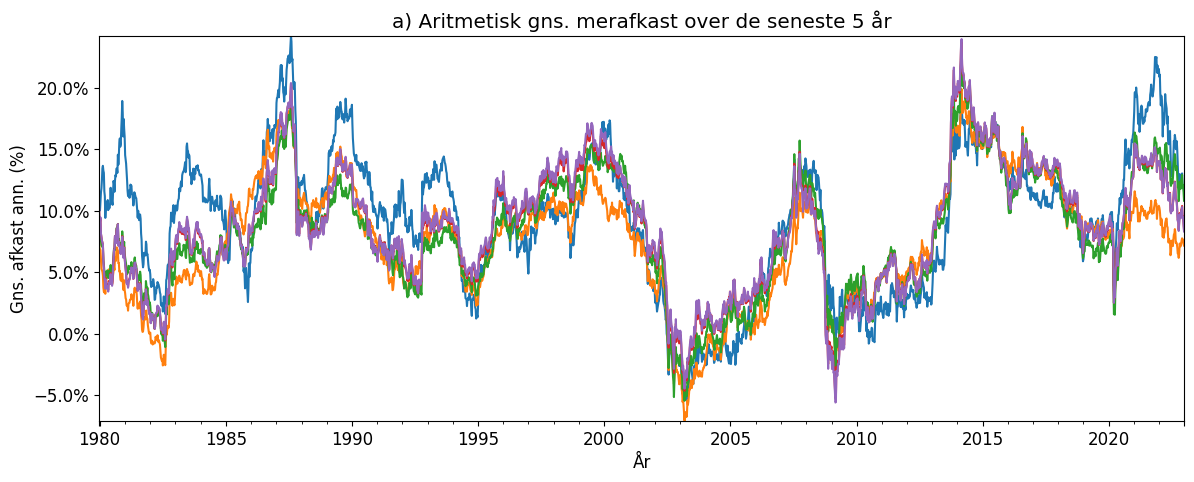

In [33]:
# 5-year rolling realized av. excessreturns (ann.)
df_yearly_excess_ret = df_port_excess_ret.rolling(52*5).mean().dropna(inplace=False) * 52

fig, ax = plt.subplots(figsize=(14, 5))

df_yearly_excess_ret.plot(ax=ax, legend=False)

ticks = ticker.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)

ax.set_title("a) Aritmetisk gns. merafkast over de seneste 5 år")
ax.set_xlabel("År")
ax.set_ylabel("Gns. afkast ann. (%)")
#plt.savefig("2_year_rolling_ret.jpg",bbox_inches="tight",dpi=300)
plt.show()

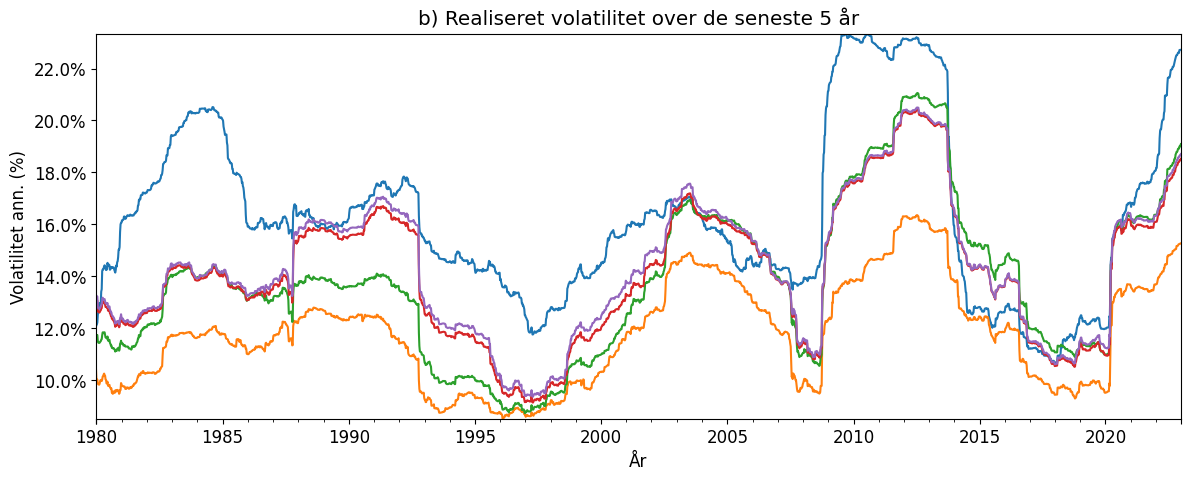

In [34]:
# 5-year rolling realized volatility (ann.)

df_yearly_std = df_port_ret.rolling(52*5).std().dropna(inplace=False) * np.sqrt(52)

fig, ax = plt.subplots(figsize=(14, 5))

df_yearly_std.plot(ax=ax, legend=False)
ticks = ticker.PercentFormatter(1, decimals=None)
ax.yaxis.set_major_formatter(ticks)

ax.set_title("b) Realiseret volatilitet over de seneste 5 år")
ax.set_xlabel("År")
ax.set_ylabel("Volatilitet ann. (%)")
#plt.savefig("2_year_rolling_vol.jpg",bbox_inches="tight",dpi=300)
plt.show()

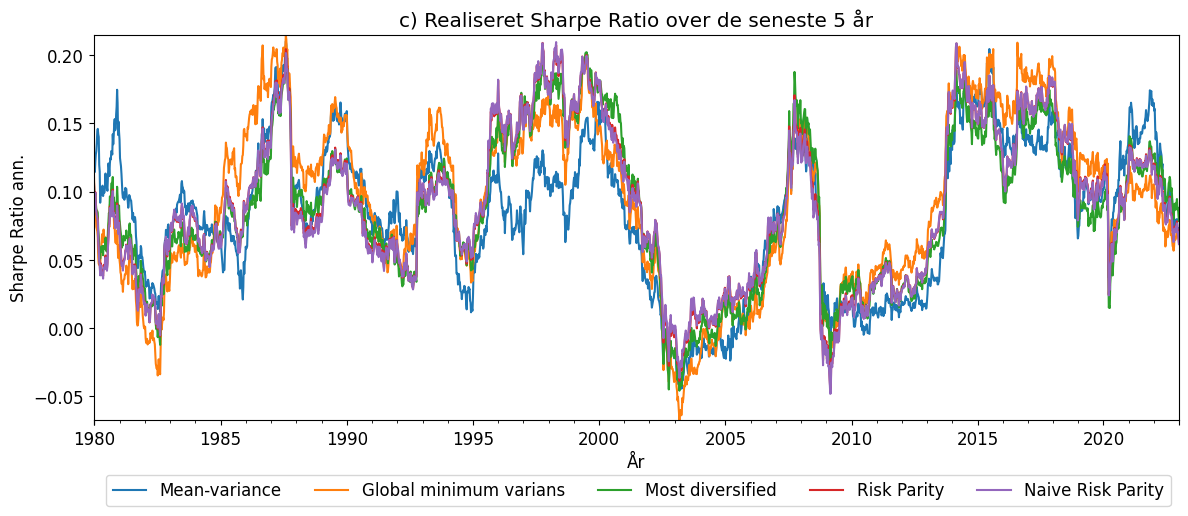

In [35]:
# 5-year rolling realized Sharpe Ratio (ann.)
df_yearly_sr = df_yearly_excess_ret/df_yearly_std / np.sqrt(52)

fig, ax = plt.subplots(figsize=(14, 5))

df_yearly_sr.plot(ax=ax, legend=None)

ax.set_title("c) Realiseret Sharpe Ratio over de seneste 5 år")
ax.set_xlabel("År")
ax.set_ylabel("Sharpe Ratio ann.")
ax.legend(legends, ncol=5, bbox_to_anchor=(1.0, -0.12))
#plt.savefig("2_year_rolling_SR.jpg",bbox_inches="tight",dpi=300)
plt.show()

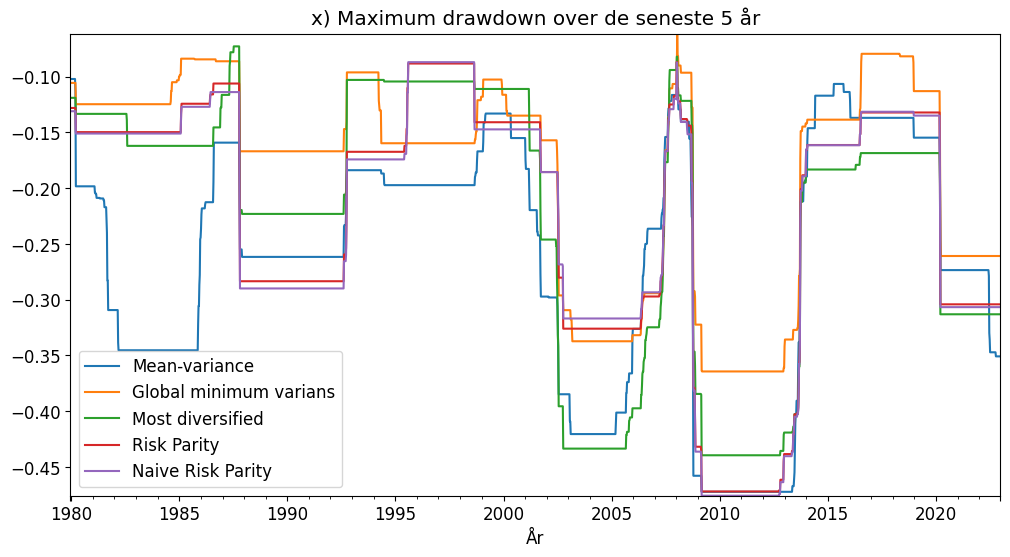

In [37]:
df_rolling_mdd = df_port_tri.rolling(5*52).apply(maxdrawdown).dropna(inplace = False)
fig, ax = plt.subplots(figsize=(12, 6))

df_rolling_mdd.plot(ax=ax)

ax.set_title("x) Maximum drawdown over de seneste 5 år")
ax.set_xlabel("År")
ax.legend(legends)
#plt.savefig("2_year_rolling_MDD.jpg",bbox_inches="tight",dpi=300)
plt.show()